In [252]:
from get_data import get_ohlcv_series
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mase
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from darts.models import KalmanFilter
from darts.models.forecasting.gradient_boosted_model import LightGBMModel
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
import json
# if __name__ == '__main__':
symbol = "BTC-USD"
df = pd.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True)
print(df.describe())
df.head()
# todo kalman before features? Have to do df -> timeseries -> df -> apply feats -> timeseries

       UTC timestamp          open          high           low         close  \
count   7.200000e+02    720.000000    720.000000    720.000000    720.000000   
mean    1.632710e+12  47275.102917  47512.128750  47044.588611  47290.734583   
std     7.487654e+08   4474.176712   4473.832542   4489.514015   4487.327318   
min     1.631416e+12  40499.900000  41051.100000  39579.000000  40499.900000   
25%     1.632063e+12  43393.375000  43687.750000  43149.150000  43392.100000   
50%     1.632710e+12  47198.250000  47401.000000  47001.500000  47214.350000   
75%     1.633357e+12  48773.600000  48977.300000  48565.050000  48838.600000   
max     1.634004e+12  57501.600000  57837.700000  57358.200000  57499.900000   

            volume  
count   720.000000  
mean    124.471403  
std     179.623526  
min       8.418664  
25%      45.444360  
50%      77.098601  
75%     142.256810  
max    2619.579706  


,UTC timestamp,open,high,low,close,volume
0,1631415600000,45299.0,45323.8,45226.3,45311.1,13.764573
1,1631419200000,45311.1,45489.8,45239.3,45342.4,20.250714
2,1631422800000,45343.3,45490.0,45248.4,45395.8,10.472641
3,1631426400000,45395.7,45415.0,45137.1,45190.3,11.760966
4,1631430000000,45190.2,45368.7,45089.2,45363.4,22.654320


In [253]:
def get_ta(df):
    # Add all ta features
    df_ta = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume")
    # df = dropna(df)
    df_ta = df_ta.drop('UTC timestamp','columns')

    # Scale feats
    ts_ta = TimeSeries.from_dataframe(df_ta,fill_missing_dates=True) #time_col="UTC timestamp")
    # scaler = Scaler()
    # scaled_covars = scaler.fit_transform(ts_ta)
    # scaled_covars.plot()
    print(df_ta.columns)

    return ts_ta

# Scale covars
def get_return_lags(df):
    # Create the lagged percentage returns columns
    lag_names = []
    for i in [1,2,3,5,8,13,21,42]:
        col_name = f"lag_return_{i}"
        lag_names.append(col_name)
        df[col_name] = df["close"].pct_change(periods=i)
        # df[col_name] = df["close"].shift(periods=i)

    
    covars = TimeSeries.from_dataframe(df, value_cols=lag_names, fill_missing_dates=True)#,time_col="UTC timestamp")
    # scaler = Scaler()
    # scaled_covars = scaler.fit_transform(covars)
    # scaled_covars.plot()
    return covars

In [254]:
# Also adds features to df
scaled_covars = get_return_lags(df)
scaled_covars = get_ta(df)

Index(['open', 'high', 'low', 'close', 'volume', 'lag_return_1',
       'lag_return_2', 'lag_return_3', 'lag_return_5', 'lag_return_8',
       'lag_return_13', 'lag_return_21', 'lag_return_42', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       't

/Users/michaelremington/opt/anaconda3/envs/stonk-pix-ai/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/michaelremington/opt/anaconda3/envs/stonk-pix-ai/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [255]:
scaled_covars.describe()

component,open,high,low,close,volume,lag_return_1,lag_return_2,lag_return_3,lag_return_5,lag_return_8,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,720.000000,720.000000,720.000000,720.000000,720.000000,719.000000,718.000000,717.000000,715.000000,712.000000,...,707.000000,687.000000,711.000000,708.000000,695.000000,687.000000,687.000000,720.000000,719.000000,720.000000
mean,47275.102917,47512.128750,47044.588611,47290.734583,124.471403,0.000343,0.000690,0.001031,0.001747,0.002758,...,-42.866815,243.801273,47244.729631,0.412819,-2.622604,-2.782655,-0.119116,0.028478,0.031430,4.368984
std,4474.176712,4473.832542,4489.514015,4487.327318,179.623526,0.007627,0.010460,0.012550,0.016163,0.020250,...,27.766888,971.843779,4401.491256,2.462846,19.091320,15.267664,10.239921,0.778195,0.762658,9.903373
min,40499.900000,41051.100000,39579.000000,40499.900000,8.418664,-0.047894,-0.055061,-0.065385,-0.083475,-0.071475,...,-100.000000,-2752.405294,41488.792562,-7.953141,-48.910730,-37.351297,-18.449559,-4.789444,-4.907937,-10.618149
25%,43393.375000,43687.750000,43149.150000,43392.100000,45.444360,-0.003226,-0.004397,-0.005353,-0.006672,-0.008354,...,-67.847337,-300.015441,43297.892759,-0.925998,-15.762489,-13.432125,-7.105500,-0.324201,-0.323094,-4.235165
50%,47198.250000,47401.000000,47001.500000,47214.350000,77.098601,0.000141,0.000243,0.000160,0.000673,0.001119,...,-37.148615,216.794706,47341.903554,0.385368,-3.023265,-2.204748,-1.545698,0.014110,0.014111,4.200406
75%,48773.600000,48977.300000,48565.050000,48838.600000,142.256810,0.003761,0.005094,0.006037,0.008948,0.013271,...,-18.903990,837.621765,48433.629544,1.773342,8.954388,6.565045,4.861717,0.375166,0.375347,7.785068
max,57501.600000,57837.700000,57358.200000,57499.900000,2619.579706,0.048991,0.057902,0.061269,0.079445,0.088551,...,-0.000000,3103.303824,56977.924738,9.117276,64.434878,37.840395,44.782317,4.899109,4.782884,26.900252


In [256]:
# Scale target
# ts = TimeSeries.from_dataframe(df, time_col="UTC timestamp", 
#                                # value_cols=["close","open","high","low","volume","trend_ema_fast","trend_ema_slow","trend_macd_diff","momentum_rsi","volume_vwap","momentum_kama"],
#                                # value_cols=['close'],
#                                fill_missing_dates=True)
ts = scaled_covars
mvf = MissingValuesFiller()
ts = mvf.transform(ts)
scaler = Scaler()
scaled = scaler.fit_transform(ts)
scaled.describe()

component,open,high,low,close,volume,lag_return_1,lag_return_2,lag_return_3,lag_return_5,lag_return_8,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.398501,0.384892,0.419906,0.399461,0.044445,0.497890,0.493560,0.524266,0.523764,0.464850,...,0.573124,0.503421,0.370616,0.491019,0.418958,0.472825,0.285970,0.497280,0.509701,0.399461
std,0.263161,0.266512,0.252515,0.263960,0.068791,0.078663,0.092467,0.098901,0.099197,0.126173,...,0.275465,0.166432,0.282521,0.143247,0.174638,0.207139,0.159193,0.080321,0.078644,0.263960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.170187,0.157069,0.200805,0.170129,0.014180,0.461108,0.448599,0.474619,0.471692,0.396294,...,0.324558,0.402698,0.117980,0.414751,0.293829,0.329548,0.183445,0.460878,0.473173,0.170129
50%,0.393981,0.378272,0.417482,0.394968,0.026302,0.495924,0.489954,0.517317,0.517104,0.454370,...,0.638251,0.499443,0.359369,0.491876,0.410870,0.476105,0.255458,0.495797,0.508035,0.394968
75%,0.486640,0.472174,0.505425,0.490512,0.051256,0.533063,0.532402,0.563890,0.568813,0.531657,...,0.809265,0.608281,0.448064,0.567985,0.523935,0.604519,0.363859,0.533063,0.545093,0.490512
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [257]:
target_var = 'close'
target_var_idx = scaled.columns.get_loc(target_var)

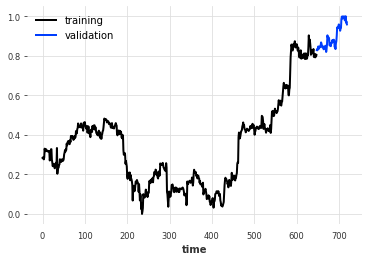

In [258]:
split = int(len(scaled) * .1) # todo split param.
train, val = scaled[:-split], scaled[-split:]
train_covar, val_covar = scaled_covars[:-split], scaled_covars[-split:]
train[target_var].plot(label='training')
val[target_var].plot(label='validation')


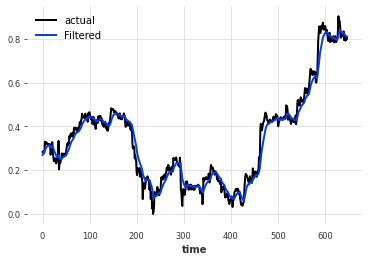

In [259]:
# Kalman Smoothing
filtered = KalmanFilter(P=1000., R=50, Q=1).filter(train[target_var])
train[target_var].plot(label='actual')
filtered.univariate_component(0).plot(label="Filtered")

In [260]:
# Train
model_cov = TCNModel(input_chunk_length=48, output_chunk_length=24, n_epochs=30, random_state=0,optimizer_kwargs={'lr':.001})
# model_cov = TransformerModel(input_chunk_length=48, output_chunk_length=24, n_epochs=21, random_state=0,optimizer_kwargs={'lr':.001})
# model_cov = RNNModel(model="GRU",input_chunk_length=48, output_chunk_length=24, n_epochs=21, random_state=0,optimizer_kwargs={'lr':.001})
# model_cov = LightGBMModel(lags=[-1,-2,-21,-34,-68,-3,-5,-8,-13])


model_cov.fit(series=train, 
              val_series=val,
              # past_covariates=train_covar, val_past_covariates=val_covar,
              verbose=True)

[2021-10-11 20:23:21,775] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 577 samples.
[2021-10-11 20:23:21,775] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 577 samples.
[2021-10-11 20:23:21,777] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 4
[2021-10-11 20:23:21,777] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 4
[2021-10-11 20:23:21,780] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-11 20:23:21,780] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/30 [00:00<?, ?it/s]

MAPE = 16.24%
sMAPE = 18.40%
MASE = 10.70%


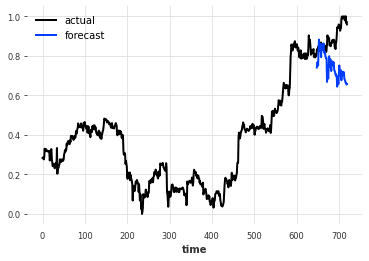

In [261]:
pred_cov = model_cov.predict(n=len(val), 
                             series=train,
                             # past_covariates=scaled_covars
                             )
scaled[target_var].plot(label='actual')
pred_cov[target_var].plot(label='forecast',low_quantile=0.05, high_quantile=0.95)
# plt.legend();
# todo MAPE
print('MAPE = {:.2f}%'.format(mape(scaled[target_var], pred_cov[target_var])))
print('sMAPE = {:.2f}%'.format(smape(scaled[target_var], pred_cov[target_var])))
print('MASE = {:.2f}%'.format(mase(scaled[target_var], pred_cov[target_var], insample=train[target_var])))

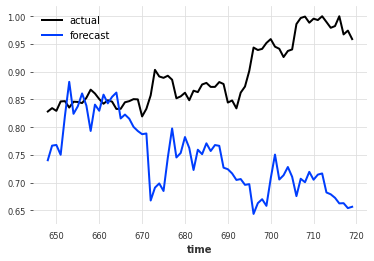

In [262]:
pred_cov = model_cov.predict(n=len(val), series=train,
                             # past_covariates=scaled_covars
                             )

val[target_var].plot(label='actual')
plt = pred_cov[target_var].plot(label='forecast')
# plt.legend();

  0%|          | 0/61 [00:00<?, ?it/s]

MAPE (using covariates) = 6.05%
sMAPE = 6.32%


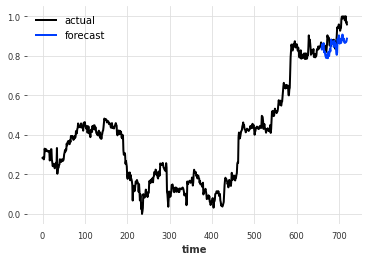

In [263]:
# historical_forecasts
backtest_cov = model_cov.historical_forecasts(scaled,
                                              # past_covariates=scaled_covars,
                                              start=len(train),
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

scaled[target_var].plot(label='actual')
# backtest_cov.plot(label='forecast')
backtest_cov.univariate_component(target_var_idx).plot(label='forecast')
# plt.legend();
backtest_mape = mape(scaled[target_var], backtest_cov.univariate_component(target_var_idx))
print('MAPE (using covariates) = {:.2f}%'.format(backtest_mape))
print('sMAPE = {:.2f}%'.format(smape(scaled[target_var], backtest_cov.univariate_component(target_var_idx))))

In [264]:
from darts.metrics import coefficient_of_variation, mae, mse, r2_score, rmse
# Backtest
backtest_error = model_cov.backtest(scaled,
                                              metric=mae,
                                              start=len(train),
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

print(backtest_error)

  0%|          | 0/61 [00:00<?, ?it/s]

0.19370463646451114


[2021-10-11 20:23:59,377] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 649 samples.
[2021-10-11 20:23:59,377] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 649 samples.


  0%|          | 0/30 [00:00<?, ?it/s]

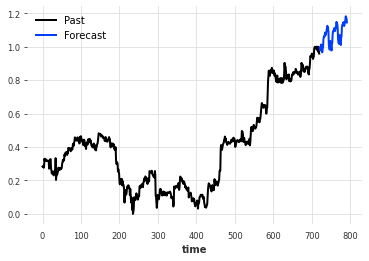

In [265]:
# Retrain on full series
model_cov.fit(series=scaled, 
              # past_covariates=train_covar, val_past_covariates=val_covar,
              verbose=True)


# Predict future
pred_cov = model_cov.predict(n=len(scaled)//10,
                             # series=scaled,
                             
                             )
scaled[target_var].plot(label='Past')
pred_cov[target_var].plot(label='Forecast')
# plt.legend()

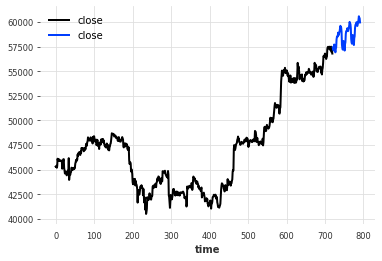

In [266]:
# JSON out
scaler.inverse_transform(scaled)[target_var].plot()
scaler.inverse_transform(pred_cov)[target_var].plot()

past_close = scaler.inverse_transform(scaled)[target_var].pd_dataframe()
prediction = scaler.inverse_transform(pred_cov)[target_var].pd_dataframe()
period = "1h"


In [268]:
# Set index to Unix timestamps
past_close.set_index(df['UTC timestamp'][:len(past_close)],inplace=True)

# Write future timestamps to predictions
timestamp_len_ms = past_close.index[1] - past_close.index[0]
future_timestamps = []
for i in range(1,len(prediction)+1):
    timestamp = past_close.index[-1]+timestamp_len_ms*i
    future_timestamps.append(timestamp)
prediction.set_index(pd.Series(future_timestamps),inplace=True)
prediction = prediction.round(2)


In [273]:
return_dict = {
    "symbol":symbol,
    "past":json.loads(past_close.to_json()),
    "prediction":json.loads(prediction.to_json()),
    "period":period,
    "MAPE":backtest_mape
}

json.dump(return_dict, open(f"{symbol}.json",'w'), indent=4)
# print(json.dumps(return_dict, indent=4))

In [72]:
#tinydb
from tinydb import TinyDB, Query
db = TinyDB('db.json')
table = db.table('forecasts')
table.insert(return_dict)

2

In [ ]:
# read json
import json
forecasts = []
for s in ['BTC-USD','ETH-USD']:
    read_json = json.load(open(f"{s}.json",'r'))
    forecasts.append(read_json)
    
# print(json.dumps(read_json, indent=4))

In [ ]:
# Start mongo if not running
!docker run -p 27017:27017 -v $(pwd):/out --rm -d mongo

In [18]:
# Write forecasts to mongo
import pymongo
client = pymongo.MongoClient("localhost", 27017)
db = client.db_name

for f in forecasts:
    db.forecasts.delete_many({'symbol':f['symbol'],'period':f['period']})
    db.forecasts.insert_one(f)

cursor = db.forecasts.find({})
for c in cursor:
    print(c['symbol'])
    
cursor = db.forecasts.find()
import pprint
# pprint.pprint(cursor)
for c in cursor:
    pprint.pprint(c.keys())

BTC-USD
ETH-USD
dict_keys(['_id', 'symbol', 'past', 'prediction', 'period', 'MAPE'])
dict_keys(['_id', 'symbol', 'past', 'prediction', 'period', 'MAPE'])


In [ ]:
# Ensemble
from darts.models.forecasting.regression_ensemble_model import RegressionEnsembleModel
from darts.models.forecasting.baselines import NaiveEnsembleModel

TCN = TCNModel(input_chunk_length=48, output_chunk_length=24, n_epochs=21, random_state=0,optimizer_kwargs={'lr':.001})
RNN = RNNModel(model="GRU",input_chunk_length=48, output_chunk_length=24, n_epochs=21, random_state=0,optimizer_kwargs={'lr':.001})
# GBM = LightGBMModel(lags=[-1,-2,-21,-34,-68,-3,-5,-8,-13])


ensemble = RegressionEnsembleModel([TCN,RNN],regression_train_n_points=4)
# ensemble = NaiveEnsembleModel([TCN,RNN])

ensemble.fit(train)

In [ ]:
pred_cov = ensemble.predict(n=len(train)//4, series=train,
                             # past_covariates=scaled_covars
                             )
target_var = 'close'
scaled[target_var].plot(label='actual')
pred_cov[target_var].plot(label='forecast',low_quantile=0.05, high_quantile=0.95)
# plt.legend();